In [1]:
# imports
from tensorflow import keras
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
import pandas as pd
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
from matplotlib import pyplot
from scipy import stats, optimize, interpolate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from time import time
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [2]:
# load a single file as a numpy array
def load_file(filepath):
    columns = ['accX', 'accY', 'accZ', 'surface']
    dataframe = read_csv(filepath,header=None, names=columns)
    return dataframe
df = load_file('5_surfaces_dataset.csv')
df

,accX,accY,accZ,surface
0,-0.002563,0.000169,0.002441,wood
1,0.007324,-0.006545,-0.001465,wood
2,0.086792,-0.169753,-0.046753,wood
3,0.093384,-0.118361,0.001587,wood
4,0.103271,-0.069289,0.009644,wood
...,...,...,...,...
23995,-0.000732,0.033369,-0.010620,carpet
23996,0.011230,0.006147,0.006836,carpet
23997,0.034668,0.022016,0.012573,carpet
23998,0.038452,0.033979,0.024536,carpet


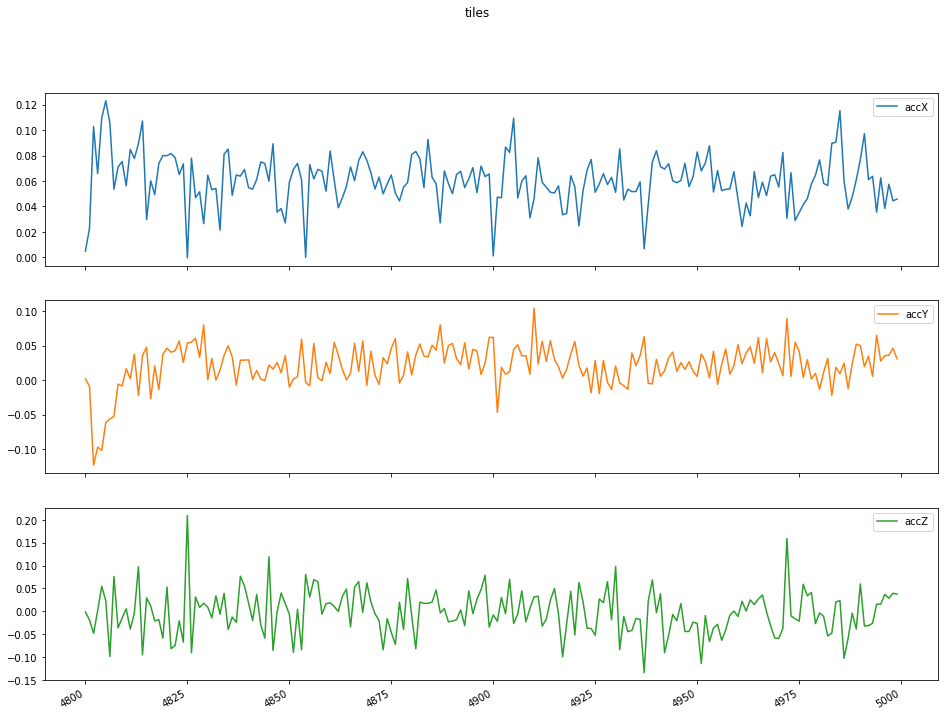

In [3]:
#plot acc values of a particular surface
def plot_surface(surface, df):
    extractRowsOfSurface = (df['surface'] == surface)
    data = df[extractRowsOfSurface]
    data = data[['accX', 'accY', 'accZ']]
    data = data.astype(float)
    data = data[:200]
    ax = data.plot(subplots=True, figsize=(16, 12), title=surface)

plot_surface('tiles', df)

In [4]:
# Encode Labels
label = LabelEncoder()
df['label'] = label.fit_transform(df['surface'])
df.head()
label.classes_

array(['carpet', 'concrete', 'gravel', 'tiles', 'wood'], dtype=object)

In [5]:
# Standardize Data
X = df[['accX', 'accY', 'accZ']]
y = df['label']

scaler = StandardScaler()
X = scaler.fit_transform(X)
scaled_X = pd.DataFrame(data = X, columns = ["accX", "accY", "accZ"])
scaled_X['label'] = y.values
scaled_X

,accX,accY,accZ,label
0,-1.476001,-0.573332,0.037156,4
1,-1.208507,-0.714847,-0.024202,4
2,0.941350,-4.154962,-0.735576,4
3,1.119679,-3.071725,0.023734,4
4,1.387173,-2.037374,0.150285,4
...,...,...,...,...
23995,-1.426465,0.126451,-0.168011,0
23996,-1.102830,-0.447331,0.106184,0
23997,-0.468771,-0.112839,0.196304,0
23998,-0.366397,0.139316,0.384214,0


In [6]:
# Data Preprocessing and Framing
## Frame Preparation
frame_size = 75 #1.5s/0.02fs
hop_size = 20 #25%

def get_frames(df, frame_size, hop_size):
    N_FEATURES = 3
    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['accX'].values[i: i + frame_size]
        y = df['accY'].values[i: i + frame_size]
        z = df['accZ'].values[i: i + frame_size]
        
        label = stats.mode(df['label'][i: i +frame_size])[0][0]
        frames.append([x, y, z])
        labels.append(label)
        
    # Reshape segments
    frames = np.asarray(frames, dtype=np.float32).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)
    
    return frames, labels

X, y = get_frames(scaled_X, frame_size, hop_size)

In [7]:
X_Train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42, stratify = y)

#Hot encode data
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_Train.shape, y_train.shape[1], X_test.shape,  y_test.shape)

(897, 75, 3) 5 (300, 75, 3) (300, 5)


In [8]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 100, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    print(n_timesteps)
    print(n_features)
    print(n_outputs)
    model = Sequential()
    model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_outputs, activation='softmax'))
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience = 2, verbose=1, restore_best_weights=True)
    # fit network
    start_train = time()
    history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(testX, testy), callbacks=[monitor])
    # evaluate model
    time_train= time()-start_train
    start_test = time()
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    time_test = time()-start_test
    return accuracy, history, time_train, time_test, model

# summarize scores
def summarize_results_accuracy(scores):
	#print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# summarize scores
def summarize_results_time_train(scores):
	#print(scores)
	m, s = mean(scores), std(scores)
	print('Time_train: %.3fs (+/-%.3f)' % (m, s))
    
# summarize scores
def summarize_results_time_test(scores):
	#print(scores)
	m, s = mean(scores), std(scores)
	print('Time_test: %.3fs (+/-%.3f)' % (m, s))

In [9]:
#change repeats
repeats = 10
scores = list()
train= list()
test = list()
for r in range(repeats):
        score, history, time_train, time_test, model = evaluate_model(X_Train, y_train,X_test, y_test)
        score = score * 100.0
        #print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
        train.append(time_train)
        test.append(time_test)


75
3
5
Restoring model weights from the end of the best epoch.
Epoch 00010: early stopping
75
3
5
Restoring model weights from the end of the best epoch.
Epoch 00008: early stopping
75
3
5
Restoring model weights from the end of the best epoch.
Epoch 00010: early stopping
75
3
5
Restoring model weights from the end of the best epoch.
Epoch 00009: early stopping
75
3
5
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
75
3
5
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
75
3
5
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
75
3
5
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
75
3
5
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
75
3
5
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping


not the right epoch to plot
not the right epoch to plot
not the right epoch to plot
not the right epoch to plot


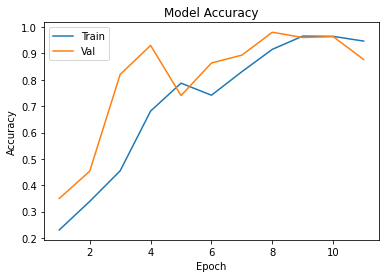

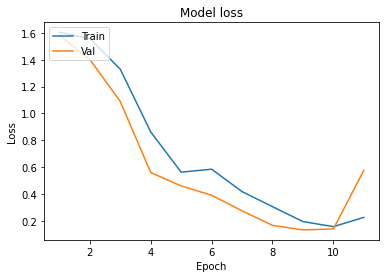

Accuracy: 91.000% (+/-8.024)
Time_train: 17.539s (+/-0.000)
Time_test: 0.175s (+/-0.000)


In [10]:
def learning_curve(history, epochs):
    epoch_range = range(1, epochs-2)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

for x in range(10, 50):
    try:
        learning_curve(history, x)
        break
    except:
        print("not the right epoch to plot")
    
# summarize results
summarize_results_accuracy(scores)
summarize_results_time_train(time_train)
summarize_results_time_test(time_test)

    

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f94842112e8>)

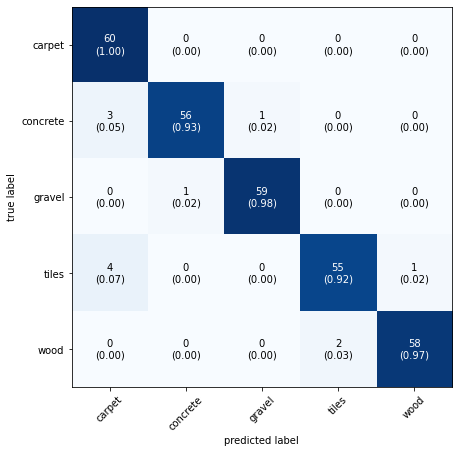

In [11]:

y_pred = model.predict_classes(X_test)
#remove one-hot encoded
rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]
mat = confusion_matrix(rounded_labels, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))



In [12]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100)               41600     
_________________________________________________________________
dropout_18 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_19 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 5)                 505       
Total params: 52,205
Trainable params: 52,205
Non-trainable params: 0
_________________________________________________________________
